### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os

### Locate raw experiment CSV files
Set the data directory, list the nine experiment CSVs, and add a helper to extract the user id from each filename.

In [2]:
from pathlib import Path

data_dir = Path("data")
csv_files = sorted(data_dir.glob("*_experiment.csv"))


def extract_userid(path: Path) -> int:
    parts = path.stem.split("_")
    try:
        return int(parts[2])
    except (IndexError, ValueError) as exc:
        raise ValueError(f"Unexpected filename format: {path.name}") from exc

pd.DataFrame({"file": [p.name for p in csv_files], "userid": [extract_userid(p) for p in csv_files]})

,file,userid
0,20251217_104912_47931_experiment.csv,47931
1,20251217_110617_54965_experiment.csv,54965
2,20251217_111631_40644_experiment.csv,40644
3,20251217_113228_59864_experiment.csv,59864
4,20251217_114106_50568_experiment.csv,50568
5,20251225_164323_91494_experiment.csv,91494
6,20251225_165742_90524_experiment.csv,90524
7,20251225_170459_53092_experiment.csv,53092
8,20251225_171313_46184_experiment.csv,46184


### Build per-user condition summary
For each CSV, compute the mean time per condition across 15 rounds, capture the condition's sequence name, and keep the user's rating; then write the consolidated table to a new CSV.

In [3]:
conditions = ["None", "Sound", "Haptics", "Both"]
rows = []

for csv_path in csv_files:
    df = pd.read_csv(csv_path, keep_default_na=False)
    user_id = extract_userid(csv_path)

    summary = (
        df.groupby("Condition", as_index=True)
        .agg(
            mean_time=("Time", "mean"),
            pattern=("SequenceName", "first"),
            score=("RatingForCondition", "first"),
        )
    )

    row = {"userid": user_id}
    for cond in conditions:
        if cond in summary.index:
            row[cond] = round(summary.loc[cond, "mean_time"], 4)
            row[f"{cond}Pattern"] = summary.loc[cond, "pattern"]
            row[f"{cond}Score"] = summary.loc[cond, "score"]
        else:
            row[cond] = pd.NA
            row[f"{cond}Pattern"] = pd.NA
            row[f"{cond}Score"] = pd.NA

    rows.append(row)

user_summary = pd.DataFrame(rows).sort_values("userid").reset_index(drop=True)
output_path = data_dir / "condition_summary_by_user.csv"
user_summary.to_csv(output_path, index=False)
user_summary

,userid,None,NonePattern,NoneScore,Sound,SoundPattern,SoundScore,Haptics,HapticsPattern,HapticsScore,Both,BothPattern,BothScore
0,40644,2.3659,PatternB,1,1.4349,PatternD,7,1.3783,PatternC,6,1.1575,PatternA,8
1,46184,2.3389,PatternC,10,3.1717,PatternD,10,2.8698,PatternB,10,2.0817,PatternA,10
2,47931,2.4124,PatternC,1,2.1206,PatternB,8,1.9583,PatternA,8,1.8721,PatternD,9
3,50568,2.3081,PatternC,1,2.3927,PatternB,9,1.9803,PatternD,8,2.2231,PatternA,6
4,53092,1.6597,PatternB,1,1.8200,PatternA,8,2.0010,PatternD,10,1.6409,PatternC,10
5,54965,1.4785,PatternA,1,1.7753,PatternC,8,1.9848,PatternD,9,1.8894,PatternB,9
6,59864,2.1513,PatternB,3,2.4335,PatternD,6,2.0893,PatternC,9,2.0957,PatternA,9
7,90524,1.6930,PatternC,2,1.5454,PatternA,7,1.7114,PatternB,5,1.6429,PatternD,8
8,91494,2.0531,PatternB,5,2.1319,PatternD,7,1.9017,PatternC,9,1.9120,PatternA,8


### Compute Means

In [5]:
mean_none = user_summary['None'].mean()
mean_sound = user_summary['Sound'].mean()
mean_haptics = user_summary['Haptics'].mean()
mean_both = user_summary['Both'].mean()
print(f"Mean of None: {mean_none:.4f}")
print(f"Mean of Sound: {mean_sound:.4f}")
print(f"Mean of Haptics: {mean_haptics:.4f}")
print(f"Mean of Both: {mean_both:.4f}")

Mean of None: 2.0512
Mean of Sound: 2.0918
Mean of Haptics: 1.9861
Mean of Both: 1.8350


### Visualizations

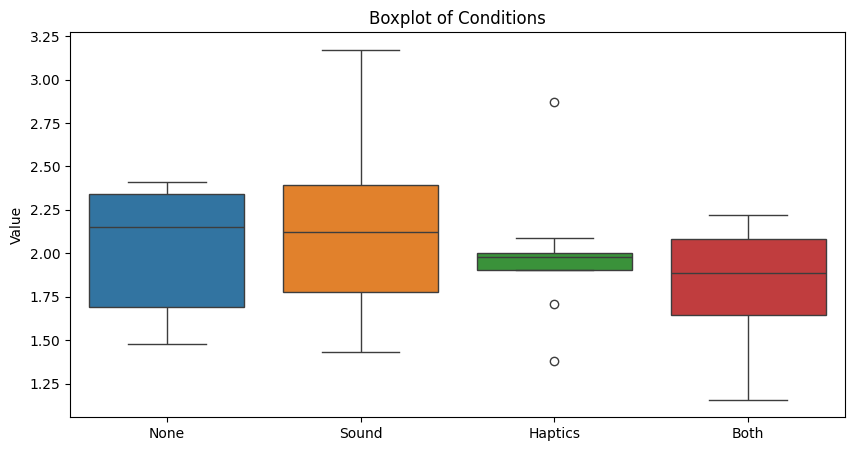

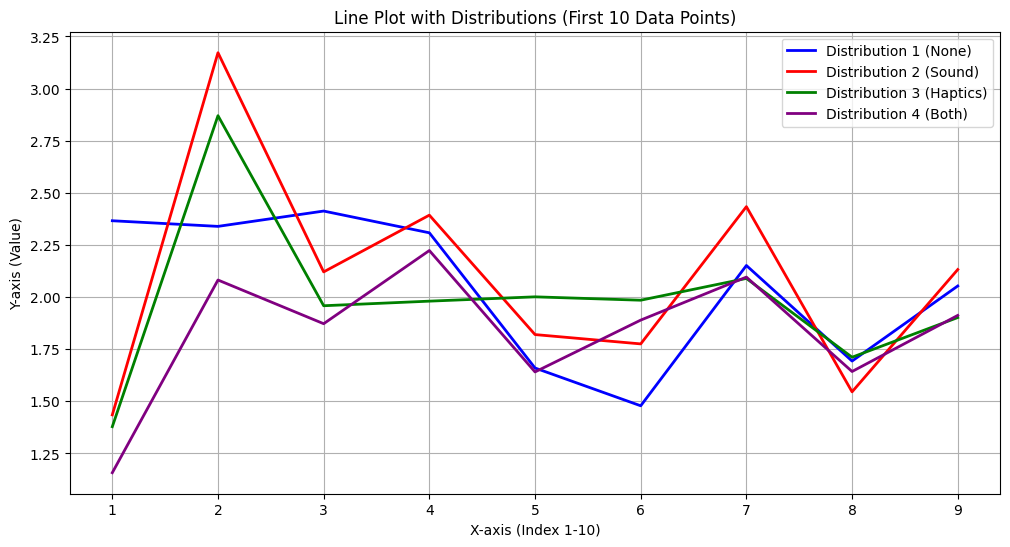

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=user_summary[['None', 'Sound', 'Haptics', 'Both']])
plt.title('Boxplot of Conditions')
plt.ylabel('Value')
plt.show()


""" plt.figure(figsize=(8, 6))
plt.scatter(user_summary['mousedata'], user_summary['stylusdata'])
plt.title('Scatter Plot of Mousedata vs Stylusdata')
plt.xlabel('Mousedata')
plt.ylabel('Stylusdata')
plt.grid(True)
plt.show() """

# Original R: Line plot with two distributions (corrected interpretation based on `x <- 1:datapoints`)
# This assumes the R code intended to plot the first "datapoints" data points against x-values 1 to datapoints.
datapoints = 9
x_data = np.arange(1, datapoints+1) # Corresponds to R's 1:datapoints+1

if len(user_summary) >= datapoints:
    plt.figure(figsize=(12, 6))
    plt.plot(x_data, user_summary['None'].iloc[:datapoints], label='Distribution 1 (None)', color='blue', linewidth=2)
    plt.plot(x_data, user_summary['Sound'].iloc[:datapoints], label='Distribution 2 (Sound)', color='red', linewidth=2)
    plt.plot(x_data, user_summary['Haptics'].iloc[:datapoints], label='Distribution 3 (Haptics)', color='green', linewidth=2)
    plt.plot(x_data, user_summary['Both'].iloc[:datapoints], label='Distribution 4 (Both)', color='purple', linewidth=2)
    plt.title('Line Plot with Distributions (First 10 Data Points)')
    plt.xlabel('X-axis (Index 1-10)')
    plt.ylabel('Y-axis (Value)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Not enough data points (less than 10) in 'user_summary' for the intended line plot.")

### Simple Statistics

In [9]:
print("Summary statistics for pointing_df:")
display(user_summary.describe())


shapiro_none = stats.shapiro(user_summary['None'])
shapiro_haptics = stats.shapiro(user_summary['Haptics'])
shapiro_sound = stats.shapiro(user_summary['Sound'])
shapiro_both = stats.shapiro(user_summary['Both'])
print(f"\nShapiro-Wilk test for user_summary['None']: Statistic={shapiro_none.statistic:.4f}, p-value={shapiro_none.pvalue:.4f}")
print(f"Shapiro-Wilk test for user_summary['Haptics']: Statistic={shapiro_haptics.statistic:.4f}, p-value={shapiro_haptics.pvalue:.4f}")
print(f"Shapiro-Wilk test for user_summary['Sound']: Statistic={shapiro_sound.statistic:.4f}, p-value={shapiro_sound.pvalue:.4f}")
print(f"Shapiro-Wilk test for user_summary['Both']: Statistic={shapiro_both.statistic:.4f}, p-value={shapiro_both.pvalue:.4f}")

Summary statistics for pointing_df:


,userid,None,NoneScore,Sound,SoundScore,Haptics,HapticsScore,Both,BothScore
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,59474.000000,2.051211,2.777778,2.091778,7.777778,1.986100,8.222222,1.835033,8.555556
std,18689.391008,0.353175,3.032234,0.533859,1.201850,0.394432,1.715938,0.320799,1.236033
min,40644.000000,1.478500,1.000000,1.434900,6.000000,1.378300,5.000000,1.157500,6.000000
25%,47931.000000,1.693000,1.000000,1.775300,7.000000,1.901700,8.000000,1.642900,8.000000
50%,53092.000000,2.151300,1.000000,2.120600,8.000000,1.980300,9.000000,1.889400,9.000000
75%,59864.000000,2.338900,3.000000,2.392700,8.000000,2.001000,9.000000,2.081700,9.000000
max,91494.000000,2.412400,10.000000,3.171700,10.000000,2.869800,10.000000,2.223100,10.000000



Shapiro-Wilk test for user_summary['None']: Statistic=0.8686, p-value=0.1189
Shapiro-Wilk test for user_summary['Haptics']: Statistic=0.8404, p-value=0.0584
Shapiro-Wilk test for user_summary['Sound']: Statistic=0.9380, p-value=0.5607
Shapiro-Wilk test for user_summary['Both']: Statistic=0.9099, p-value=0.3151


### ANOVA

In [10]:
# One-way ANOVA across the four conditions
none_vals = user_summary['None'].dropna()
sound_vals = user_summary['Sound'].dropna()
haptics_vals = user_summary['Haptics'].dropna()
both_vals = user_summary['Both'].dropna()

anova_res = stats.f_oneway(none_vals, sound_vals, haptics_vals, both_vals)
print(f"F-statistic: {anova_res.statistic:.4f}, p-value: {anova_res.pvalue:.4f}")

# Optional: statsmodels formulation for richer output
long_df = user_summary.melt(id_vars='userid', value_vars=['None', 'Sound', 'Haptics', 'Both'],
                            var_name='Condition', value_name='Time').dropna()
model = ols('Time ~ C(Condition)', data=long_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
display(anova_table)

F-statistic: 0.6848, p-value: 0.5679


,sum_sq,df,F,PR(>F)
C(Condition),0.343180,3.0,0.68476,0.567939
Residual,5.345804,32.0,NaN,NaN
